## 2. Fasea: Algoritmoak diseinatzen

In [76]:
import sys
import numpy as np
import random
import copy
from time import time
import matplotlib.pyplot as plt
import pickle
import math

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
!pip3 install ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
#directory = "/content/drive/MyDrive/Universidad/4.Maila/BH/BH laboak/BH Praktika/"
directory = "/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/"
#directory = ""

sys.path.append(directory)

In [80]:
from ipynb.fs.full.CDP_Sarrera_Ikasle import sortu_grafoa, bistaratu_grafoa
from ipynb.fs.full.CDP_1_fasea_Ikasle import modularitatea

Problemaren enuntziatuan ez da zehazten zenbat komunitatetan banatu behar diren nodoak. Datuen azterketan balio egokia zein izan litekeen aztertu genuen, baina fase honetan k=10 balioa erabiliko dugu. Beste balio batzuekin ere proba batzuk egin ditzakegu.

In [81]:
G = sortu_grafoa() #Grafoa sortu
n = G.number_of_nodes() #n= nodo kopurua
k=10 #k = komunitate kopurua (guk zehaztua)

In [82]:
#Grafoa, komunitate kopurua eta nodo kopurua emanda ausazko soluzio bat itzultzen du
def sortu_soluzioa(G,k,n):
  return np.random.randint(k,size=n)

#Aldagai globalak

In [83]:
#ALDAGAI GLOBALAK HASIERATU

#Nodoen izenen lista (indizetik izenera pasatzeko)
nodoak = list(G.nodes)

#Grafoko ertz guztien pisuen batura
m = G.size(weight="weight") 

#Nodoen izenetatik indizera pasatzeko hiztegia
indizeak = dict()
ind = 0
for nodo in nodoak:
  indizeak[nodo] = ind
  ind+=1

#Lortu nodo batetik besterako ertzen pisuen matrizea (ertza ez badago pisua=0)
pisuak = np.zeros((n,n))
for i in range(n):
    for j in range(n):
      lag = G[nodoak[i]]
      if  nodoak[j] in lag: #dira auzokideak
          pisuak[i,j] = lag[nodoak[j]]["weight"]

#Nodoen graduak eskuratzeko. Dena den, guk graduak erabili ordez nodoari konektatutako ertzen pisuen baturak erabiliko ditugu modularitatean.
# graduak = []
# for i in range(n):
#   graduak.append(G.degree(nodoak[i]))

#Nodo baten gradua beregana konektatutako ertz guztien pisuen batura kontsideratuko dugu
graduak = []
for i in range(n):
  graduak.append(np.sum(pisuak[i]))

#Modularitate funtziorako aurrekalkulatu i eta j nodo pare posible guztien graduen biderketak 
graduMul = np.zeros((n,n))
for i in range(n):
    for j in range(n):
      graduMul[i,j] = graduak[i]*graduak[j]/(2*m)

#Modularitatea

In [84]:
ii, jj = np.ogrid[:n, :n]
def modularitatea(G, solution):
    n = G.number_of_nodes()
    ii, jj = np.ogrid[:n, :n]
    value = np.sum(np.where(solution[ii]==solution[jj], pisuak[ii,jj]-graduMul[ii,jj], 0)) 
    return value/(2*m)

#Ingurune funtzioak

3 oinarrizko ingurune dauzkagu: hamming, swap eta insert. Problema honen definizioa eta kodeketa kontuan hartuta, badirudi hamming ingurunea izango dela egokiena. Izan ere insert eta swap inguruneetan hasierako soluzioaren komunitate tamainak konstante mantentzen dira, eta beraz, hasierako soluzioak asko baldintzatzen du bilaketa espazioa. Aldiz, hamming ingurunea soluzio batetik abiatuta gai da kobinazio posible guztietara iristeko. 

Dena den, soilik hamming ingurunea erabili beharrean, hirurekin probak egingo ditugu gure hipotesia zuzena den ikusteko.

In [85]:
#Sortu ausazko zenbaki bat emandako tarteetan eta x ez dena.
def randint_exclude(start,end,x):
  y = np.random.randint(start,end)

  while x == y:
    y= np.random.randint(start,end)
  return y

#Sortu ausazko bektore bat, emandakoaren dimentsio berekoa eta bere zenbakiak errepikatu gabe.
def randvec(diag):
  vec = np.empty(shape=len(diag))
  for i in range(len(diag)):
    vec[i] = randint_exclude(0,k-1,diag[i])
  return vec

def hamming_ingurune(G, solution):
  
  ingurunea = np.copy(solution)
  n = len(list(G.nodes()))
  ingurunea = np.tile(ingurunea, (n, 1)) #klonatu errenkada n aldiz (n auzokide hamming ingurunean)
  rand_vec = randvec(np.diag(ingurunea)) #Sortu ausazko bektore bat 
  ingurunea[np.diag_indices(n)] = rand_vec #Ordezkatu matrizearen diagonala bektorearekin

  return ingurunea



solution = sortu_soluzioa(G,k,n)
hamming_ingurunea = hamming_ingurune(G, solution)
print(hamming_ingurunea)
print(len(hamming_ingurunea))


[[8 7 0 ... 2 6 7]
 [3 3 0 ... 2 6 7]
 [3 7 5 ... 2 6 7]
 ...
 [3 7 0 ... 8 6 7]
 [3 7 0 ... 2 5 7]
 [3 7 0 ... 2 6 6]]
1843


Ikusi dugu swap edo insert ingurune osoa sortzeak RAM memoria guztia xahutzen duela. Hori dela eta, 2 ingurune hauek modu progresibo batean sortzeko funtzioak garatu ditugu.

In [86]:
#Emandako (i,j) indizeek definitzen duten insert eragiketaren hurrengo indizeak itzultzen ditu
def hurrengo_insert(i,j, n):
  j_ = j+1
  if j_ == i:
    j_ +=2
  if j_ == i+1:
    j_ +=1
  if j_>n:
    return i+1,0
  return i,j_ 

#Insert inguruneko auzokide bat itzultzen du, emandako (i,j) insert eragiketa kontuan hartuta (i elementua j posizioan txertatu)
#Bestela konbinazio gehiegi (n^2-n), eta RAM memoria xahutzen da.
def insert_auzokide(solution, n,i=0,j=2):

  neighbour = list(solution)
  neighbour.insert(j,neighbour[i])
  if j>i:
    neighbour.pop(i) #Kendu listatik hasieran zegoen agerpena
  else:
    neighbour.pop(i+1) #Kendu listatik hasieran zegoen agerpena (j<i denez eskuinera mugitu da)
  neighbour = np.asarray(neighbour)

  i,j = hurrengo_insert(i,j, n)

  return neighbour,i,j

In [87]:
#Emandako (i,j) indizeek definitzen duten swap eragiketaren hurrengo indizeak itzultzen ditu
def hurrengo_swap(i,j,n):
  j_ = j+1
  if j_ == i:
    j_ +=1
  if j_>=n:
    return i+1,i+2
  return i,j_ 

#Swap inguruneko auzokide bat itzultzen du, emandako (i,j) swap eragiketa kontuan hartuta (i eta j posizioetako elementuak trukatu)
def swap_auzokide(solution, n, i=0,j=1):

  neighbour = np.copy(solution)
  neighbour[i],neighbour[j] = neighbour[j],neighbour[i]

  i,j = hurrengo_swap(i,j, n)

  return neighbour,i,j

Inguruneen eraginkortasunari buruzko gure hasierako hipotesia frogatzeko helburuarekin, bakoitzak sortzen dituen auzokideen fitness-ak aztertuko ditugu, hasierako soluzioarekin konparatuz. Kasurik onenean ingurune funtzioak iterazioro fitness-a hobetzen joan behar du; gertuko soluzioak antzekoak izanik eta gero eta urrunago joan orduan eta ezberdintasun handiagoa dagoelarik. \

In [88]:
#Auzokideen auzokideak ateratzeko funtzioa adierazitako alditan(steps) egingo da. Hamming ingurunearekin erabiliko dugu
#funtzio hau besteek(swap eta insert) collab-ek uzten duen RAM memoria osoa xahutzen dutelako. 
def funtzio_lag(subG, steps, current_sol, fitness, datuak, i, func):
  #steps -= 1
  if steps == i:
    return 0
  else:
    ingurunea = func(subG, current_sol)
    for j, sol in enumerate(ingurunea):
      diff = modularitatea(subG,sol) - fitness
      datuak[i].append(diff)
      funtzio_lag(subG, steps, sol, fitness, datuak, i+1, func)

#Auzokideen auzokideak ateratzeko funtzioa adierazitako alditan(steps) egingo da. Funtzio honetan progresiboki eraikitzen dira
#inguruneak eta horrela collab-eko RAM memoria optimogoki erabiltzen dugu. Insert eta swap inguruneeakin erabiliko 
#dugu funtzio hau, izan ere, bi inguruneak guztiz sortzen baditugu collb-eko RAM memoria bukatzen da.
def funtzio_lag_insert_hamming(subG, steps, current_sol, fitness, datuak, i, func, n, z):
  #steps -= 1
  if steps == i:
    return 0
  else:
    k=0
    j=z
    while k != n:
      auzokidea,k,j = func(current_sol, n, i=k,j=j)
      diff = modularitatea(subG,auzokidea) - fitness
      datuak[i].append(diff)
      funtzio_lag_insert_hamming(subG, steps, auzokidea, fitness, datuak, i+1, func, n, z)


#Dei errekurtsiboei hasiera emateko funtzioa auzokideen auzokideak lortzeko.
def ebaluatu_ingurunea_errekurtsiboa(subG,steps,ingurune_fun="hamming"):
  first_sol = sortu_soluzioa(subG,k,len(list(subG.nodes())))
  fitness = modularitatea(subG,first_sol)
  funtzioak = [insert_auzokide, swap_auzokide, hamming_ingurune ]
  ing_ebaluazioak = []
  i = 0
  j = 0
  n = len(list(subG.nodes))
  #hur_ingurune = hamming_ingurune(first_sol)
  for func in funtzioak:
    datuak = []
    for _ in range(steps):
      datuak.append([])
    if "hamming" == ingurune_fun:
      funtzio_lag(subG, steps, first_sol, fitness, datuak, i, funtzioak[2])
    elif "insert" == ingurune_fun:
      j = 2
      funtzio_lag_insert_hamming(subG, steps, first_sol, fitness, datuak, i, funtzioak[0], n, j)
    elif "swap" == ingurune_fun:
      j = 1
      n-=1
      funtzio_lag_insert_hamming(subG, steps, first_sol, fitness, datuak, i, funtzioak[1], n, j)
    ing_ebaluazioak.append(copy.deepcopy(datuak))
    break

  return ing_ebaluazioak

Dena den, esan bezala inguruneak lortzea kostu handikoa da. Hortaz, grafo osoarekin lan egin beharrean 20 nodoko azpigrafo batekin arituko gara. 20 nodo hauek gradu altuenekoak izango dira. 

In [89]:
#Grafoaren azpigrafo bat egiteko
subGrafo = copy.deepcopy(G)
nodoak = list(G.nodes())
geratu = []

for i in range(len(nodoak)):
  if G.degree(nodoak[i]) >= 13:
    geratu.append(nodoak[i])

geratu.pop(4)
subGrafo = subGrafo.subgraph(geratu)

In [90]:
#Azpigrafo berriak dituen nodo kopurua
len(list(subGrafo.nodes()))

20

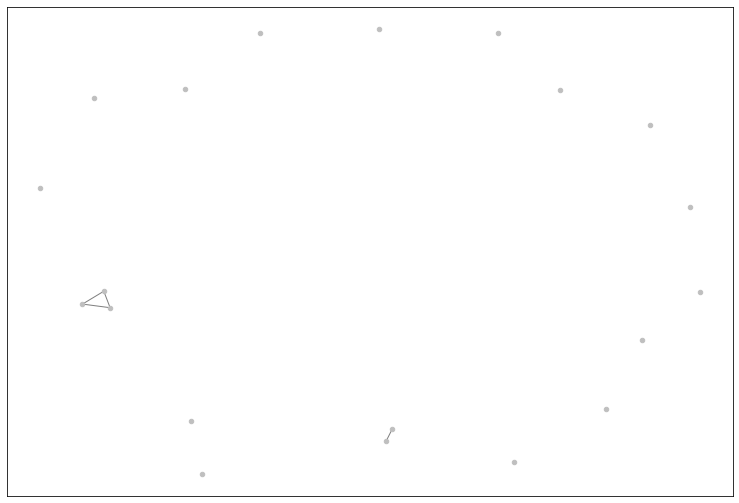

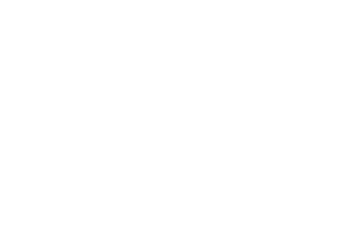

In [91]:
#Azpigrafo berria bistaratzen
bistaratu_grafoa(subGrafo)

In [92]:
#Auzokideen auzokideak lortu eta gordetzeko dira hurrengo aginduak
#filename = '/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/insert'
#outfile = open(filename,'wb')
#has = time()
#ingurune_datuak = ebaluatu_ingurunea_errekurtsiboa(subGrafo,3,"insert")
#buk = time()
#pickle.dump(ingurune_datuak, outfile)
#outfile.close()

In [93]:
filename = '/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/Hamming'
infile = open(filename,'rb')
hamming_datuak = pickle.load(infile)
infile.close()
filename = '/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/swap'
infile = open(filename,'rb')
swap_datuak = pickle.load(infile)
infile.close()
#filename = '/content/drive/MyDrive/4.Kurtsoa/BH/BH Praktika/insert'
#infile = open(filename,'rb')
#swap_datuak = pickle.load(infile)
#infile.close()

Nahiz eta azpigrafo batekin aritu, insert ingurunea ebaluatzeak kostu handiegia du (Google Collab-eko RAM memoria xahutzen du). Ondorioz, soilik swap eta hamming konparatuko ditugu atal honetan. \

Hainbat soluziotatik abiatuta, swap eta hamming inguruneak kalkulatu ditugu 3 pausoko sakoneran, eta hauek izan dira eskuratu ditugun emaitzak:

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


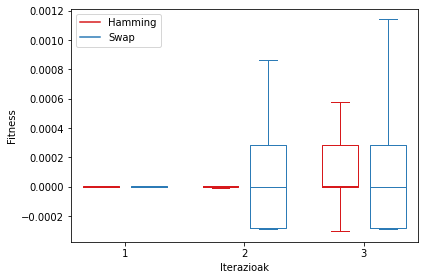

In [94]:
import matplotlib.pyplot as plt
ingurune_datuak1 = hamming_datuak + swap_datuak

data_a = ingurune_datuak1[0][:3] #hamming
data_b = ingurune_datuak1[1] #swap

ticks = ['1', '2', '3']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='Hamming')
plt.plot([], c='#2C7BB6', label='Swap')
plt.legend()

plt.xlabel("Iterazioak")
plt.ylabel("Fitness")

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
#plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()
plt.savefig('boxplot.png')

Grafiko honek gure hipotesia egikaritzen du, hamming eta swap konparatzerakoan, gutxienez. Ikusten den bezala, swap inguruneak 3 iteraziotan fitness balio gehienak hasierako soluzioaren inguruan mantentzen ditu. Aldiz, begietsi daiteke hamming pixkanaka hobetzen doala pausoak aurrera doazen heinean. 

#Soluzio bakarrean oinarritutako algoritmoa: Simulated Annealing

Soluzio bakarrean algoritmo gisa Local Search familiakoa den estrategia bat erabiltzea bururatu zaigu. Izan ere, algoritmo hauek ezagunak dira eta emaitza onak erakus ditzakete. Baina Local Search-ean oinarritzen diren estrategia asko existitzen dira, eta horietatik guztietatik, Simulated Annealing inplementatzea erabaki dugu. Batez ere, tenperatura bezalako aldagai estokastikoak baliatzen dituelako eta oinarri probabilistikoa duen algoritmo bat delako. Hona hemen algoritmoaren pseudokodea:

    #Simulated annealing(G, max_evals, buk_prob, tries )
      #hasieratu(best_solution, best_fitness, evals, epsilon, tenperatura(T), amaierako_tenperatura(T_buk))
      #solution = best_solution
      #fitness = best_fitness
      #loop until evals <max_evals:
        #solution-en ingurunea lortu

        #loop i in 0..tries-1
          #auzokidea = hartu inguruneko auzokide bat ausaz
          #aukeratutako auzokidea ebaluatu
          #evals += 1
          #Kalkulatu fitness diferentzia solution-ekiko

          #if Auzokidearen fitness-a hobea bada
            #Eguneratu fitness, solution
            #Oraingo soluzioa best_solution baino hobea bada
              #Eguneratu best_fitness eta best_solution
              #break (best first)

          #if Onartu txarragoak diren soluzioak probabilitate batekin
            #fitness eta solution eguneratu
            #break

          #if Ebaluazio kopuru maximora iritsi bada
            #break

        #Tenperatura eguneratu

      #return (best_fitness, best_solution, evals)

Algoritmoan hasierako eta amaierako tenperatura emandako probabilitateen arabera kalkulatzen dira. Hortaz, parametro gisa probabilitate zehatzak pasa diezazkiokegu, eta honek modu errazago batean erabiltzea ahalbidetzen du. \
*Oharra: orain ezarrita dauden probabilitateak ez ditugu oinarri teoriko edo esperimental bat jarraituta ipini. Beraz, 3. fasean gehiago aztertuko ditugu balio ezberdinak. 

In [95]:
import numpy as np
import random
import math
import community
import networkx.algorithms.community as nx

#Simulated Annealing
def simulated_annealing(G,max_evals,has_prob=0.7,buk_prob=0.01,tries=50, ingurune_func = "hamming"):
  best_solution = np.random.randint(k,size=n) #Hasi ausazko soluzio batetik
  best_fitness = modularitatea(G,best_solution)
  evals=1
  aurreko_evals = 1
  epsilon = 0.0001 
  T = -1/math.log(has_prob) #Hasierako tenperatura
  T_buk = -1/math.log(buk_prob) #Amaierako tenperatura
  T_erredukzioa = (T_buk/T)**(1/(max_evals-1)) #Eval bakoitzerako egingo zaion erredukzioa

  E_avg = 0 #Fitness diferentzien batazbestekoa gordetzeko
  onartuak = 0 #Onartuak izan diren auzokide kopurua (txarragoak nahiz hobeak)
  hamming = False
  insert = False
  z = 1
  #n = len(list(G.nodes))
  print_interval = max_evals/10
  if "hamming" == ingurune_func:
    print("hamming")
    hamming = True
    func = hamming_ingurune
  elif "insert" == ingurune_func:
    print("insert")
    insert = True
    func = insert_auzokide
  elif "swap" == ingurune_func:
    print("swap")
    func = swap_auzokide

  solution = best_solution
  fitness = best_fitness
  fitness_list = []
  while evals <max_evals:
    if hamming:
      ingurunea = func(G, solution)
      ausazko_indizeak = random.sample(range(len(ingurunea)),tries) #Ingurunea ausazko ordenean atzitzeko
    else:
      kk = 0
      z = 1
      if insert:
        z = 2 
      auzokidea, kk, z = func(solution, n, i=kk,j=z)

    for i in range(tries): #Gehienez auzokide kopuru mugatu bat aztertu, eta gero tenperatura eguneratu
      if hamming:
        neighbour = ingurunea[ausazko_indizeak[i]]
      else:
        if i != 0:
          neighbour, kk, z = func(auzokidea, n, i=kk, j = z) 
        else:
          neighbour = copy.deepcopy(auzokidea)
      fit = modularitatea(G,neighbour)
      evals+=1
      if evals % print_interval ==0:
        print(f"evals {evals}/{max_evals}")
      E = fitness - fit #Kalkulatu fitness diferentzia
      if E<0: #auzokidearen fitness-a handiagoa da eta beraz hobea
        fitness = fit
        solution = neighbour
        fitness_list.append(fitness)
        onartuak+=1 #Onartu diren soluzioak inkrementatu
        if fit > best_fitness: 
          best_fitness = fit
          best_solution = neighbour
          break
      elif math.exp(-E/(E_avg*T+epsilon))> random.random(): #Probabilitate batekin onartu soluzio txarragoa
        onartuak+=1 #Onartu diren soluzioak inkrementatu
        fitness = fit
        solution = neighbour
        fitness_list.append(fitness)
        E_avg = (E_avg * (onartuak + E)) / onartuak #Eguneratu batazbesteko E (fitness diferentzia)
        break

      if evals >max_evals-1: #Ebaluazio kopuru maximora iritsi bada bukatu
        break


    T -= T_erredukzioa*(evals-aurreko_evals) #Tries aldiz iteratu ondoren tenperatura erreduzitu
    aurreko_evals = evals
   
  return (best_fitness, list(best_solution),evals, fitness_list)


In [96]:
#Grafikoa sortzeko
start=time()
max_evals = 1000
(fitness,sol,evals, fitness_list_insert) = simulated_annealing(G,max_evals, ingurune_func = "insert")
end=time()

(fitness,sol,evals, fitness_list_swap) = simulated_annealing(G,max_evals, ingurune_func = "swap")
(fitness,sol,evals, fitness_list_hamming) = simulated_annealing(G,max_evals, ingurune_func = "hamming")

# Inprimatu balioak pantailan.
print("Best fitness solution ",fitness, sol)
print("Execution time: ",end-start)
print("Evaluations consumed: ",evals)

insert
evals 100/1000
evals 200/1000
evals 300/1000
evals 400/1000
evals 500/1000
evals 600/1000
evals 700/1000
evals 800/1000
evals 900/1000
evals 1000/1000
swap
evals 100/1000
evals 200/1000
evals 300/1000
evals 400/1000
evals 500/1000
evals 600/1000
evals 700/1000
evals 800/1000
evals 900/1000
evals 1000/1000
hamming
evals 100/1000
evals 200/1000
evals 300/1000
evals 400/1000
evals 500/1000
evals 600/1000
evals 700/1000
evals 800/1000
evals 900/1000
evals 1000/1000
Best fitness solution  0.058427653341728246 [8, 0, 6, 5, 0, 0, 5, 3, 3, 3, 1, 4, 2, 4, 1, 1, 7, 6, 6, 9, 3, 1, 1, 9, 1, 1, 9, 7, 7, 6, 9, 8, 9, 3, 9, 4, 2, 1, 3, 1, 3, 3, 6, 7, 7, 8, 7, 0, 0, 7, 1, 3, 9, 5, 8, 5, 2, 0, 4, 6, 6, 2, 2, 7, 7, 4, 0, 6, 5, 4, 8, 8, 6, 8, 1, 9, 4, 7, 7, 0, 3, 9, 0, 1, 4, 7, 2, 3, 1, 5, 7, 4, 7, 5, 5, 5, 0, 0, 2, 3, 0, 2, 0, 5, 3, 2, 7, 2, 2, 5, 6, 9, 4, 8, 1, 7, 9, 9, 7, 6, 1, 6, 7, 3, 2, 8, 1, 2, 7, 2, 4, 6, 4, 4, 0, 2, 2, 3, 6, 0, 7, 6, 4, 4, 6, 9, 4, 0, 2, 8, 7, 9, 3, 6, 1, 3, 3, 9, 7, 0, 5,

Simulated Annealing algoritmoaren errendimendua 3 inguruneekin probatu dugu, eta exekuzio bakoitzaren fitness eboluzioak gorde ditugu. Grafikoan jarri ezkero:

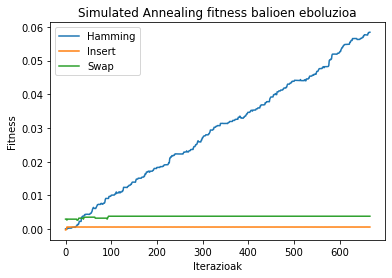

In [97]:
# create data
mini = min(len(fitness_list_hamming), min(len(fitness_list_insert), len(fitness_list_swap)))
x = np.arange(mini)
  
# plot lines
plt.plot(x, fitness_list_hamming[:mini], label = "Hamming")
plt.plot(x, fitness_list_insert[:mini], label = "Insert")
plt.plot(x, fitness_list_swap[:mini], label = "Swap")
plt.legend(loc = 'upper left')
plt.title("Simulated Annealing fitness balioen eboluzioa")
plt.xlabel("Iterazioak")
plt.ylabel("Fitness")
plt.show()

Grafikoan garbi ikus dezakegu hamming inguruneak orokorrean emaitza hobeak ematen dituela. Izan ere, ingurune honek esplorazio joera handiagoa du, soluzio baten komunitateen agerpenen proportzioa aldatzen duelako. Insert eta swap inguruneak, berriz, soluzioko permutazio berriak sortzen dituzte eta honen ondorioz komunitateen agerpenen proportzioa berdin geldituko da. Hau da, jatorrizko soluzioan i komunitateko 7 agerpen badaude insert eta swap inguruneetan beti 7 agerpen egongo dira auzokideen artean eta hamming ingurunean ez.

Honen bitartez, ondorioztatu dezakegu insert eta swap inguruneak erabiltzen baditugu, seguruenik jatorrizko modularitatetik gertu dagoen emaitza bat lortuko dugula. Hala ere, problema honetan nodoen proportzio hori aldatu gabe ere emaitzak asko aldatu daitezke, baina, jatorrizko soluzioak proportzio on bat edukitzearen dependente izango dira. Beraz, hamming inguruneak esplorazioa bermatzen du, eta jatorrizko soluziotik independenteagoa da soluzioko komunitateen proportzioak ez dituelako mantentzen. Berriz, insert eta swap inguruneak jatorrizko soluzioa gehiago esplotatzen dute.

Ondorioz, algoritmoak probatzeko eta hasierako emaitza batzuk lortzeko hamming ingurunea erabiltzea erabaki dugu, izan ere, insert eta swap inguruneak duten murrizketa gehiegizkoa iruditzen zaigu. Hala ere, estrategia ideala lehenengo hamming ingurunea erabiltzea izango litzateke, eta ondoren insert eta swap inguruneak erabiltzea lortutako soluzioa esploratzeko. Hau proiektu honen 3. zatian egingo dugu hamming eta insert-swap inguruneen arteko elkarlana nolakoa den ikusteko.  

#Algoritmo poblazionala: Estimation of Distribution Algorithms (EDA)

Algoritmo poblazionalak aipatzen diren bakoitzean algoritmo genetikoak etortzen zaizkigu burura. Baina hauei ez diegu oinarri probabilistiko sendoa ikusten. Oinarri beretik abiatuz, EDA algoritmoa topatu dugu. Funtsean algoritmo genetikoen ideia bera planteatzen du, baina gurutzaketa eragiketa bat definitu ordez, populazioaren banaketa probabilistikotik lagintzen dira soluzio berriak. Noski, mutazioaren kontzeptua kontserbatzen du, bestela, esplorazioa ez litzateke bermatuta egongo. 2 mutazio proposatzen ditugu: soluzioko 2 ausazko balio trukatzea "kop" aldiz, edo "kop" adina balio ausaz aldatzea. "Kop" balio hori guk definitu beharko dugu. 

Hauxe da EDA algoritmoaren pseudokodea:

In [98]:
#EDA(G, max_iters, populationSize, numCross, mutProb)
  #population = populazioa_sortu(populationSize)
  #modularitateak = populazioko kideen modularitateen lista

  #loop max_iters
    #banaketa = populazioan oinarritutako banaketa probabilistikoa atera
    #loop numCross
      #kide_berria = sortu umea populazioko banaketa probabilistikoan oinarrituta
      #Mutatu mutProb probabilitatearekin
      #Ordezkatu populazioko kiderik txarrena berriarengatik
      #Eguneratu populazioko modularitatea
  #Lortu populazioko kiderik hoberena eta honen modularitatea
  #return kiderik_hoberena, kiderik_hoberenaren_modularitatea

Funtzio lagungarriak inplementatu ditugu:

In [99]:
#Emandako kopuru adina kide dituen populazioa sortzen du
def populazioa_sortu(populationSize):
  population = []

  for _ in range(populationSize):
    population.append(np.random.randint(0, k, n))
  
  return population

#Emandako kideari mutazio jakin bat aplikatzen dio (modua = 0 -> trukatu ausaz bi balio; modua = 1 -> aldatu kidearen balioen %20 ausaz)
def mutatu(kidea, modua =1):
  berria = kidea
  kop = int(len(kidea)/5)

  if modua==0: #Swap
    for _ in range(kop):
      lag = random.sample(range(len(kidea)),2) #Lortu ausazko 2 zenbaki ezberdin
      berria[lag[0]], berria[lag[1]] = berria[lag[1]], berria[lag[0]]

  elif modua==1: #random
    lag = random.sample(range(len(kidea)),kop) #Lortu kop adina ausazko zenbaki ezberdin
    for elem in lag:
      berria[elem] = random.randint(0,k-1)
  else:
    print("Mutatzeko modu zenbaki okerra")

  return berria 

#Emandako populazioaren banaketa probabilistikoa itzultzen du
def banaketa_prob(population):
  banaketa = []
  for i in range(n): #Posizio bakoitzeko
    banaketaPos = np.zeros(k,dtype = np.float16) #k komunitate adina balio posible
    for kide in population:
      banaketaPos[kide[i]]+=1 #Kontatu komunitate bakoitzaren agerpenak

    banaketaPos /= n-banaketaPos[-1] #Zatitu batura osoarengatik, hau da, n. 
    banaketaPos[-1]= 1-np.sum(banaketaPos[:-1]) #Azken posizioa 1-besteak eginez kalkulatu, probabilitateen batura zehazki 1 izan dadin.
    banaketa.append(banaketaPos)
  return banaketa

#Emandako banaketa probabilistikoa jarraituz soluzio berri bat sortzen du
def sortu_umea(banaketa):
  return np.asarray([np.random.choice(np.arange(k), p=banaketa[i]) for i in range(n)]) 


Eta azkenik, EDA algoritmoaren kodea:

In [100]:
#Estimation of Distribution Algorithms (EDA)
def EDA(G,max_iters, populationSize=20, numCross = 10, mutProb = 0.02):
  """
  - param G: sarrerako grafoa
  - param max_iters: Zenbat aldiz eguneratuko den populazioa
  - param populationSize: Populazioan egongo diren soluzioen kopurua
  - param numCross: Iterazio bakoitzean zenbat soluzio berri sortuko diren
  - param mutProb: Soluzio berriak mutatzeko probabilitatea

  - return best_solution: Amaierako populazioko soluziorik onena
  - return best_fitness: Soluzio onenaren modularitate balioa
  """
  population = populazioa_sortu(populationSize)
  modularitateak = np.asarray([modularitatea(G,kide) for kide in population]) #Lortu populazioaren helburu-funtzioak
  modularity_evolution = np.empty((max_iters+1,populationSize))
  modularity_evolution[0][0] = np.max(modularitateak)
  modularity_evolution[0][1] = np.average(modularitateak)

  for i in range(max_iters): 

    banaketa = banaketa_prob(population) #Lortu populazioaren banaketa probabilistikoa

    for _ in range(numCross): 
        berria = sortu_umea(banaketa)
        if random.random()<mutProb: #Lagindu mutatzeko probabilitatea
          berria = mutatu(berria)
        min_index = np.argmin(modularitateak) #Lortu modularitate balio minimoa duen soluzioaren indizea populazioan
        population[min_index] = berria #Ordezkatu soluzio txarrena berriarengatik
        modularitateak[min_index] = modularitatea(G,berria) #Eguneratu helburu-funtzioa

    modularity_evolution[i+1][0] = np.max(modularitateak)
    modularity_evolution[i+1][1] = np.average(modularitateak)

  max_index = np.argmax(modularitateak) #Lortu populazioko soluzio onenaren indizea
  best_solution = population[max_index]
  best_fitness = modularitateak[max_index]

  return best_solution, best_fitness,modularity_evolution

In [101]:
N = 100 #Egingo diren saiakera kopurua optimoa bilatzeko.
has = time()
best_solution, best_fitness, mod_evolution = EDA(G,N, populationSize=20, numCross = 15, mutProb = 0.1)
buk = time()

# Azken emaitza:
print("Soluzio onena:",best_fitness,best_solution)
print(f"Behar izandako denbora: {buk-has} s")

Soluzio onena: 0.012929833955595313 [7 3 8 ... 2 5 7]
Behar izandako denbora: 184.83874559402466 s


EDAren errendimendua aztertzeko, iterazioro populazioko soluzioen fitness maximoa eta batazbestekoa gorde ditugu. Grafiko honetan ikus daitezke:

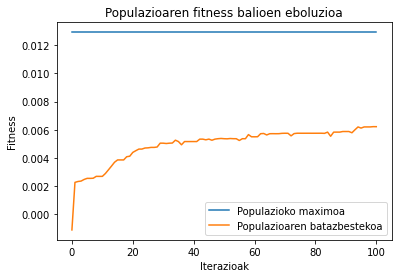

In [102]:
# imports
import plotly.express as px
import pandas as pd
import numpy as np

# create data
x = np.arange(len(mod_evolution))
  
# plot lines
plt.plot(x, mod_evolution[:,0], label = "Populazioko maximoa")
plt.plot(x, mod_evolution[:,1], label = "Populazioaren batazbestekoa")
plt.legend()
plt.title("Populazioaren fitness balioen eboluzioa")
plt.xlabel("Iterazioak")
plt.ylabel("Fitness")
plt.show()

Dirudienez, EDA algoritmoak ez du oso ongi funtzionatzen. Populazioaren batazbesteko modularitatea hobetzen doa, baina maximoa estankatuta geratzen da, eta hori da gehien interesatzen zaiguna. Ematen duenez, 100 iteraziotan ez du lortzen hasierako populazioko kide onena baino hobeagorik lortzea. Hori bai, maximoa eta batazbestekoa nahiko urrun daude. Hortik ondorioztatu dezakegu dibertsitatea mantentzen duela. 

Hortaz, 3. fasean algoritmo honi ukitu batzuk eman beharko dizkiogu, eta ez dugu baztertzen gehiago optimizatzea, denbora dexente behar baitu bere exekuzioak.

#Algoritmo eraikitzailea: GRASP

Hasieran, Community Detection problemaren deskripzioa emanda, zaila iruditzen zitzaigun arazo honetarako algoritmo eraikitzaile bat planteatzea. Beraz, jada ezagutzen ditugun estrategien artean bat aukeratzea erabaki dugu. Lehenengo bururatu zaigun algoritmoa GRASP da, baina ez dugu topatu paper-ik non GRASP erabiltzen duten Community Detection problema ebazteko. Hori dela eta, bilaketa eremua zabaldu dugu eta antzeko problemen paper-ak begiratu ditugu. Horietako batean GRASP algoritmoa Clustering problemarako erabili dela ikusi dugu. Zehazki paper-ak "A GRASP algorithm for Clustering" izena du eta egileak J.R. Cano, O. Cordón, F. Herrera eta L. Sánchez dira. Hona hemen esteka:
http://www.lsi.us.es/iberamia2002/confman/SUBMISSIONS/385-raaaiuecoh.pdf 

Azken finean, Community Detection arazoa Clustering-ekin konpara dezakegu, bietan helburua elementuak multzokatzea baita, multzoaren barruko kohesioa maximizatzeko helburuarekin. Clustering pixka bat haratago doa, bertan multzoak elkarren artean ezberdinak izatea lortu nahi baita. Hala ere, bertan aplikatutako estrategiak gure probleman baliagarriak izan daitezkela uste dugu. Beraz, azaldutako paper-eko GRASP algoritmoa hartu dugu oinarritzat. Bereziki "construction phase" atalean zentratu gara, hau da, soluzio inkrementalki eratzeko zatian.

Ideia nagusia da komunitate bakoitza ahalik eta onenen ordezkatuko duen k nodoak aurkitzea, non k = komunitate kopurua den. Hau da, nodo horiek multzoen zentrotzat hartu ditzakegu, eta haiek izango dira multzokatuko diren lehenengoak. Guk "seed" izendatuko ditugu, paper-ean bezala. Behin hori eginda, geratzen diren nodoak multzokatuko dira zentroekiko duten erlazioaren arabera. Noski, gure helburura egokitu dadin aldaketa batzuk egin dizkiogu. Horietatik nabariena da Clustering probleman "nodoak" elkarren artean konparatzeko ezaugarrien distantziak erabiltzen direla. Aldiz, gure kasuan modularitate funtzioko zati bat erabiliko dugu, eta horrela i nodo bat m multzoan sartzeak soluzioaren modularitatean izango duen eragina estimatu dezakegu. Zehazki, ertzen pisuen eta nodoen graduen (gure kasuan pisuen baturen) arteko diferentzia baliatuko dugu. Hona hemen pseudokodea: 

    # GRASP(G, greedy_prob, num_onenak)

      # hasieratu(solution, remaining, seeds)

      # first_seed = grafoko zentroa
      # ezarri 0 komunitatea first_seed-eri
      # sartu seeds bektorean
      # kendu remaining listatik

      # k seed aukeratu ez diren bitartean
      #   Estimatu n remaining nodo bakoitza seed bihurtzeak emango lukeen aportazioa
      #   Lortu aportazio handienak ematen dituzten num_onenak adina nodo
      #   Onenetatik bat ausaz aukeratu hurrengo seed gisa
      #   Eguneratu seeds, soluzio eta remaining bektoreak

      # loop node komunitate bat esleituta ez duten nodoak (remaining)
      #   Hasieratu aportazioen lista, komunitate kopurukoa
      #   loop i komunitate guztiak
      #     Lortu node nodoak (oraingo nodoak)  i komunitatera sartzeak ematen duen aportazioa
      #   Greedy aukera (onena) hartu greedy_prob probabilitatearekin
      #   bestela
      #     Hartu num_onenak aportazio onenak ematen dituzten multzoen artean 1 ausaz (greedy aukera kenduta)

      # return solution, modularitatea(G,solution), seeds



Pseudokodean azaltzen den bezala, pleanteatutako GRASP algoritmoak hasierako "seed" bat behar du. Paper-an planteatzen da instantzia zentratuena hartzea. Gure kasuan, grafoko zentrua den nodoa hartu beharko dugu. Hau lortzeko, networkx paketeko 2 funtzio baliatu ditugu:

    #Computing centrality
      networkx.degree_centrality() 

    #Computing betweeness
      networkx.betweenness_centrality()

Funtzio bakoitzak nodoen zentraltasuna lortzeko kalkulu ezberdinak egiten ditu. Informazio gehiagorako: 

  [degree_centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality) \

  [betweenness_centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality) \

Hortaz, estrategia bakoitzarekin 5 nodo zentratuenak lortuko ditugu, eta gero, 2 estrategien zerrendetatik nodo onena hautatuko dugu:


In [103]:
import networkx as nx
from networkx.generators import *
import matplotlib.pyplot as plt

#Computing centrality
degCent = nx.degree_centrality(G)

#Descending order sorting centrality
degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))

#Computing betweeness
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)

#Descending order sorting betweeness
betCent_sorted=dict(sorted(betCent.items(), key=lambda item: item[1],reverse=True))

#Color for regular nodes
color_list=n*['lightsteelblue']

#Getting indices on top 5 nodes for each measure
N_top=5
keys_deg_top=list(degCent_sorted)[0:N_top]
keys_bet_top=list(betCent_sorted)[0:N_top]

print(keys_deg_top)
print(keys_bet_top)

#Computing centrality and betweeness intersection
inter_list=list(set(keys_deg_top) & set(keys_bet_top))

print("Onenak:",inter_list)


['Yoshua Bengio', 'Michael I. Jordan', 'Lawrence Carin', 'Le Song', 'Pradeep K. Ravikumar']
['Prateek Jain', 'Nagarajan Natarajan', 'Pradeep K. Ravikumar', 'Daniel J. Hsu', 'Kamalika Chaudhuri']
Onenak: ['Pradeep K. Ravikumar']


Ikusten den bezala, 2 estrategiak erabilita 'Pradeep K. Ravikumar' izeneko nodoa da zentratuena. Hortaz, hau izango da first_seed gure GRASP algoritmoan. Hona hemen inplementazioa:

In [104]:
zentroa = "Pradeep K. Ravikumar"

#Soluzio partzialean nodo berriari emandako multzoa ezartzean modularitateari emango dion aportazioaren estimazio bat itzultzen du.
def lortu_aportazioa(solution,berria,multzo):
  aportazioak = np.where(solution[ii]==multzo,pisuak[berria,ii]-graduMul[berria,ii],0)
  count = np.count_nonzero(aportazioak == 1)
  return np.sum(aportazioak)

def GRASP(G, greedy_prob, num_onenak = 10):
  solution = np.full(n,-1) #Hasieratu soluzioa denak -1 jarriz
  
  remaining = dict() #Hasieratu multzoa esleitzeko falta diren nodoen hiztegia
  for i in range(n):  
    remaining[i]=True 

  aportazioak = pisuak-graduMul #Lortu aportazioen matrizea (modularitateko zati bat)

  seeds = np.full(k-1,-1,dtype=np.int32) #Hasieratu seeds bektorea. Seed-ak komunitateko zentro bezala hartuko ditugu.

  first_seed = indizeak[zentroa] #Lehenengo komunitatearen seed-a grafoaren zentroa izango da
  solution[first_seed] = 0
  seeds[0] = first_seed
  remaining.pop(first_seed)

  for komunitate in range(1,k-1): #Lortu falta diren k-1 seed-ak

    Dj = np.amax(aportazioak[seeds[seeds>=0]], axis=0)
    Dj = np.tile(Dj, (n, 1)) #klonatu lerroak
    Cij= Dj-aportazioak
    Cij= np.where(Cij>0,Cij,0) #max(Cij,0) numpy estiloan

    baturak = Cij.sum(axis=0)
    baturak[seeds[seeds>-1]] = -1 #Ez utzi seed-ak errepikatzen. Aurretik hartuta daudenei -1 balioa jarri.

    onenak = np.argpartition(baturak, len(baturak) - num_onenak)[-num_onenak:] #itzuli num_onenak adina maximoren indizeak
    new_seed = random.choice(onenak) #Aukeratu ausaz seed bat onenen artean (GRASP erara)
    seeds[komunitate] = new_seed
    solution[new_seed] = komunitate

    remaining.pop(new_seed)

  for node in remaining: #Falta diren nodoak iteratu
    aportazioak = np.empty(k) #Hasieratu aportazioen lista, komunitate kopurukoa

    for multzo in range(k): #Komunitate bakoitzeko
      aportazioak[multzo] = lortu_aportazioa(solution,node,multzo) #Lortu "node" nodoa "multzo" komunitatera gehitzeak ematen duen aportazioa

    if np.random.uniform()<greedy_prob: #Greedy aukera hartu greedyProb probabilitatearekin
      solution[node] = np.argmax(aportazioak)
    else: #bestela
      onenak = np.argpartition(aportazioak, len(aportazioak) - num_onenak)[-num_onenak-1:-1] #itzuli num_onenak adina onenen indizeak (greedy aukera kenduta)
      solution[node] = np.random.choice(onenak) #Hartu num_onenak aportazio onenak ematen dituzten multzoen artean 1 ausaz

  return solution, modularitatea(G,solution), seeds


In [105]:
has = time()
best_solution, best_fitness, zentroak = GRASP(G,greedy_prob=0.95,num_onenak = 10)
buk = time()

# Azken emaitza:
print("Soluzio onena:",best_fitness,best_solution)
print("Banaketa:" , np.unique(best_solution,return_counts=True)[1])
print("Zentroak:" , zentroak)
print(f"Behar izandako denbora: {buk-has} s")

Soluzio onena: 0.7702982117364452 [9 9 9 ... 6 3 4]
Banaketa: [197 198 197 160 155 186 224 175 188 163]
Zentroak: [  78   31 1029  444  280   97 1027  226 1028]
Behar izandako denbora: 1.2347941398620605 s


#Algoritmo eraikitzaile propioa

Inkrementala azalpena:

GRASP algoritmoaz gain, saiatu gara gure kabuz beste algoritmo eraikitzaile bat diseinatzen. Hainbat saiakera egin ostean, antzeko estrategia batera iritsi garela konturatu gara. Dena den, gure ustez aurrez azaldutako GRASP-en gakoa multzo bakoitzeko seed onenak bilatzean datza. Hortaz, zati hori aldatu dugu. Gure kasuan, seed-ak bilatzeko oinarri teoriko sendo bat erabili ordez, ausaz aukeratzen ditugu. Interesgarria izan daiteke ikustea ea merezi duen baliabideak xahutzea multzoetako zentru onenak topatzen, ala ausaz aukeratutako batzuk jada ongi funtzionatzen duten. Gainera, ausazkotasun gehiago sartzen diogu. Algoritmoaren pseudokodea honakoa da:

    #inkrementala(G, greedy_prob, num_onenak)
      
      #hasieratu(solution, remaining)
      #zentroak = ausazko k zenbaki ezberdin

      #Soluzioa eguneratu, zentro bakoitza komunitate batean
      #Zentroko nodoak remaining listatik kendu.

      #loop remaining nodoak
        #aportazioak lista hasieratu komunitate kopuruko luzerarekin
        #lortu oraingo nodoak komunitate bakoitzean ematen duen aportazioa eta aportazioak listan sartu
        #if greedy_prob probabilitatearekin Greedy aukera hartu
          #komunitatea = aportazio handienaren indizea
        #Bestela
          #komunitatea = num_onenak aportazio handienenetatik bat ausaz hartu, Greedy aukera kenduz
        #solution[oraingo nodoa] = komunitatea
      
      #return solution, zentroak

Eta jada inplementatuta:

In [106]:
#Soluzio partzialean nodo berriari emandako multzoa ezartzean modularitateari emango dion aportazioaren estimazio bat itzultzen du.
def lortu_aportazioa(solution,berria,multzo):
  aportazioak = np.where(solution[ii]==multzo,pisuak[berria,ii]-graduMul[berria,ii],0)
  count = np.count_nonzero(aportazioak == 1)
  return np.sum(aportazioak)

def inkrementala(G, greedyProb = 0.95, num_onenak = None):
  """
  - param G: sarrerako grafoa
  - param greedyProb: Nodo bat aportazio maximoa ematen dion multzoan sartzeko probabilitatea (Greedy aukerarena)
  - param num_onenak: Greedy aukera hartu ezean onenetatik zenbat multzo kontsideratuko diren, horietatik ausaz hartzeko (GRASP bezala)

  - return solution: Eraikitako soluzioa
  - return zentroak: Multzo bakoitzaren zentroa (hasieran zegoen nodoa)
  """

  if num_onenak == None:
    num_onenak=round(math.log(k)/ math.log(10))+1 #num_onenak defektuz k-ren 10 oinarriko logaritmoa +1

  solution = np.full(n,-1) #Hasieratu soluzioa denak -1 jarriz
  remaining = list(range(n)) #Hasieratu multzoa esleitzeko falta diren nodoen lista
  zentroak = random.sample(range(n), k) #Hartu ausazko k zentru
  zentroak.sort(reverse=True) #Ordenatu zentroak handitik txikira

  for i in range(k): #Zentro bakoitzeko
    remaining.pop(zentroak[i]) #Kendu zentroa remaining listatik
    solution[zentroak[i]]=i #Esleitu multzoa zentroari
  
  for node in remaining: #Falta diren nodoak iteratu
    aportazioak = np.empty(k) #Hasieratu aportazioen lista, komunitate kopurukoa

    for multzo in range(k): #Komunitate bakoitzeko
      aportazioak[multzo] = lortu_aportazioa(solution,node,multzo) #Lortu "node" nodoa "multzo" komunitatera gehitzeak ematen duen aportazioa

    if np.random.uniform()<greedyProb: #Greedy aukera hartu greedyProb probabilitatearekin
      solution[node] = np.argmax(aportazioak)
    else: #bestela
      onenak = np.argpartition(aportazioak, len(aportazioak) - num_onenak)[-num_onenak-1:-1] #itzuli num_onenak adina onenen indizeak (greedy aukera kenduta)
      solution[node] = np.random.choice(onenak) #Hartu num_onenak aportazio onenak ematen dituzten multzoen artean 1 ausaz

  return solution, zentroak
  #aportazioak = np.where(autistak[ii]>0 and pisuak[autistak[ii],jj]-graduMul[autistak[ii],jj]>threshold,ii,-1)

solution, zentroak = inkrementala(G)
modularitatea(G,solution)



0.7816869788535538

Oharra: num_onenak balioa zehazten ez bada, defektuz komunitate kopuruarekiko logaritmoa erabiltzen dugu, 10 oinarrikoa. Ideia nagusia da k handitu ahala kandidatu gehiago onartzea, baina gehiegi izan gabe. Dena den, balio hau ez dugu gehiegi aztertu; ataza hau 3. faserako utziko dugu.

Orain arte egindako probetan, 2 algoritmo eraikitzaileek antzeko emaitzak eman dituzte. Baina logikoa den bezala, GRASP algoritmoak denbora gehiago behar du seed-ak bilatzeko. Dena den, dirudienez grafo konkretu honetan ez du gehiegi axola multzo bakoitzarentzat seed ona topatzeak, eta ausazko hasieraketa batekin ere emaitza onak lor daitezke. Baina ezin dezakegu esan gure algoritmoa orokorreak hobea denik, soilik grafo instantzia batean egin baititugu probak. Hori dela eta, 2 algoritmoak kontserbatuko ditugu.